# Medical Image Classification with MONAI

In [1]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, resnet18
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.45.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## Continue working with OrganMNIST3d 64x64x64

In [2]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

100%|██████████| 361470105/361470105 [00:05<00:00, 67393655.48it/s]


Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [3]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [4]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [5]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [6]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        axial, coronal, sagittal = self.extract_2d_slices(data)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}

        if self.transform:
            data['axial'] = self.transform(data['axial'])
            data['coronal'] = self.transform(data['coronal'])
            data['sagittal'] = self.transform(data['sagittal'])

        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(data):
        axial = data[:, data.shape[1] // 2, :, :]
        coronal = data[:, :, data.shape[2] // 2, :]
        sagittal = data[:, :, :, data.shape[3] // 2]
        return axial, coronal, sagittal

In [7]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
def montage(dataset, length=20, replace=False, save_folder='dataset', flag = 'axial'):
    from medmnist.utils import montage2d

    imgs = []

    n_sel = length * length
    sel = np.random.choice(dataset.__len__(), size=n_sel, replace=replace)
    
    if flag == 'axial':
        slice = 0
    elif flag == 'coronal':
        slice = 1
    else:
        slice = 2
    
    for idx in sel:
        imgs.append((dataset[idx]['images'][slice]*255).astype(np.uint8))
        
    montage_img = montage2d(np.array(imgs)[:, 0],
                            n_channels=n_channels,
                            sel=range(0, n_sel))
    
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        montage_img.save(os.path.join(save_folder,
                                        f"{data_flag}{flag}_montage.png"))

    return montage_img

### Slices

In [25]:
idx = np.random.choice(train_dataset_.__len__(), size=10, replace=False)

idx

array([746, 110, 463, 313,   7, 888, 684, 620, 554, 772])

In [26]:
def show_slice(dataset, idx):

    fig, axs = plt.subplots(3,10)

    for i, index in enumerate(idx):
        x1, x2, x3 = dataset[index]['images']
        y = dataset[index]['label']

        ax = axs[0, i]
        ax.imshow(x1[0].numpy(), cmap='gray')
        ax.set_title(f'{y}')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[1, i]
        ax.imshow(x2[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[2, i]
        ax.imshow(x3[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.axis('off')
    plt.figure(figsize=(7,15))
    plt.show()

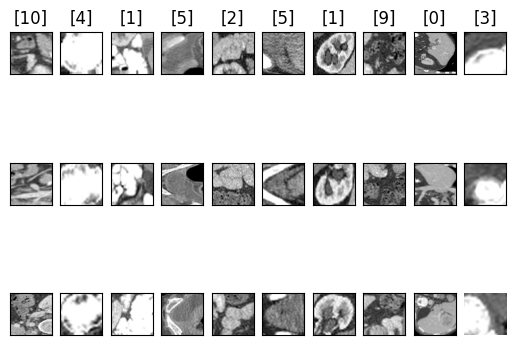

<Figure size 700x1500 with 0 Axes>

In [27]:
show_slice(train_dataset_, idx)

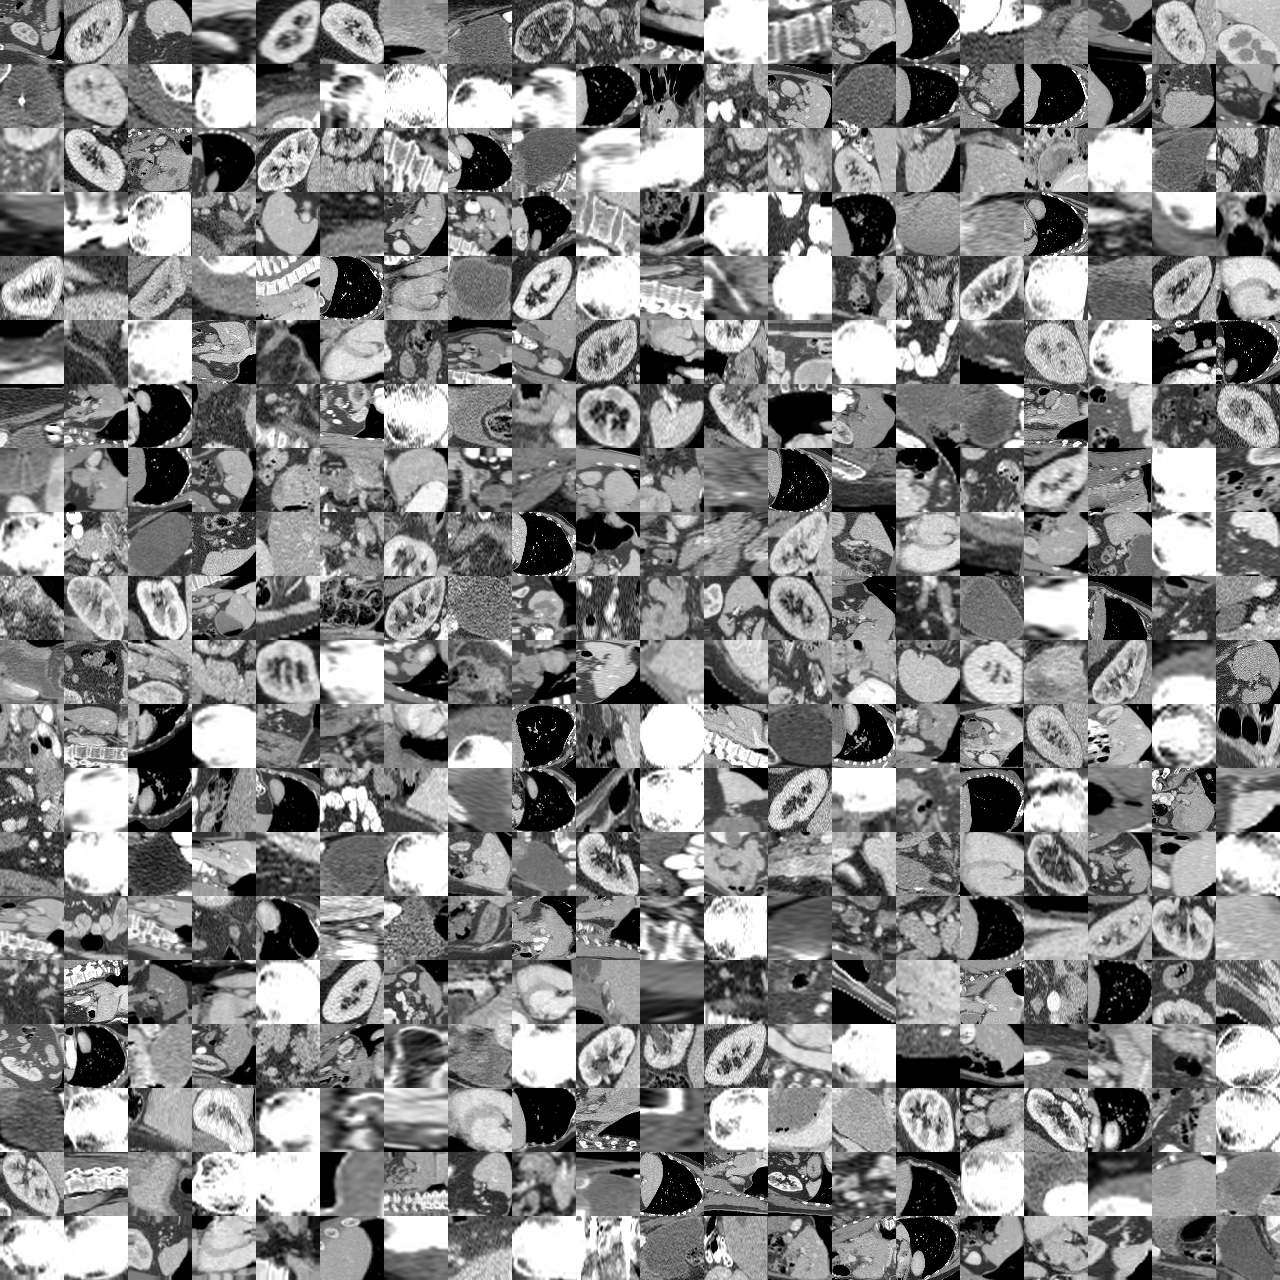

In [28]:
montage(train_dataset_, length=20, replace=False, flag = 'axial')

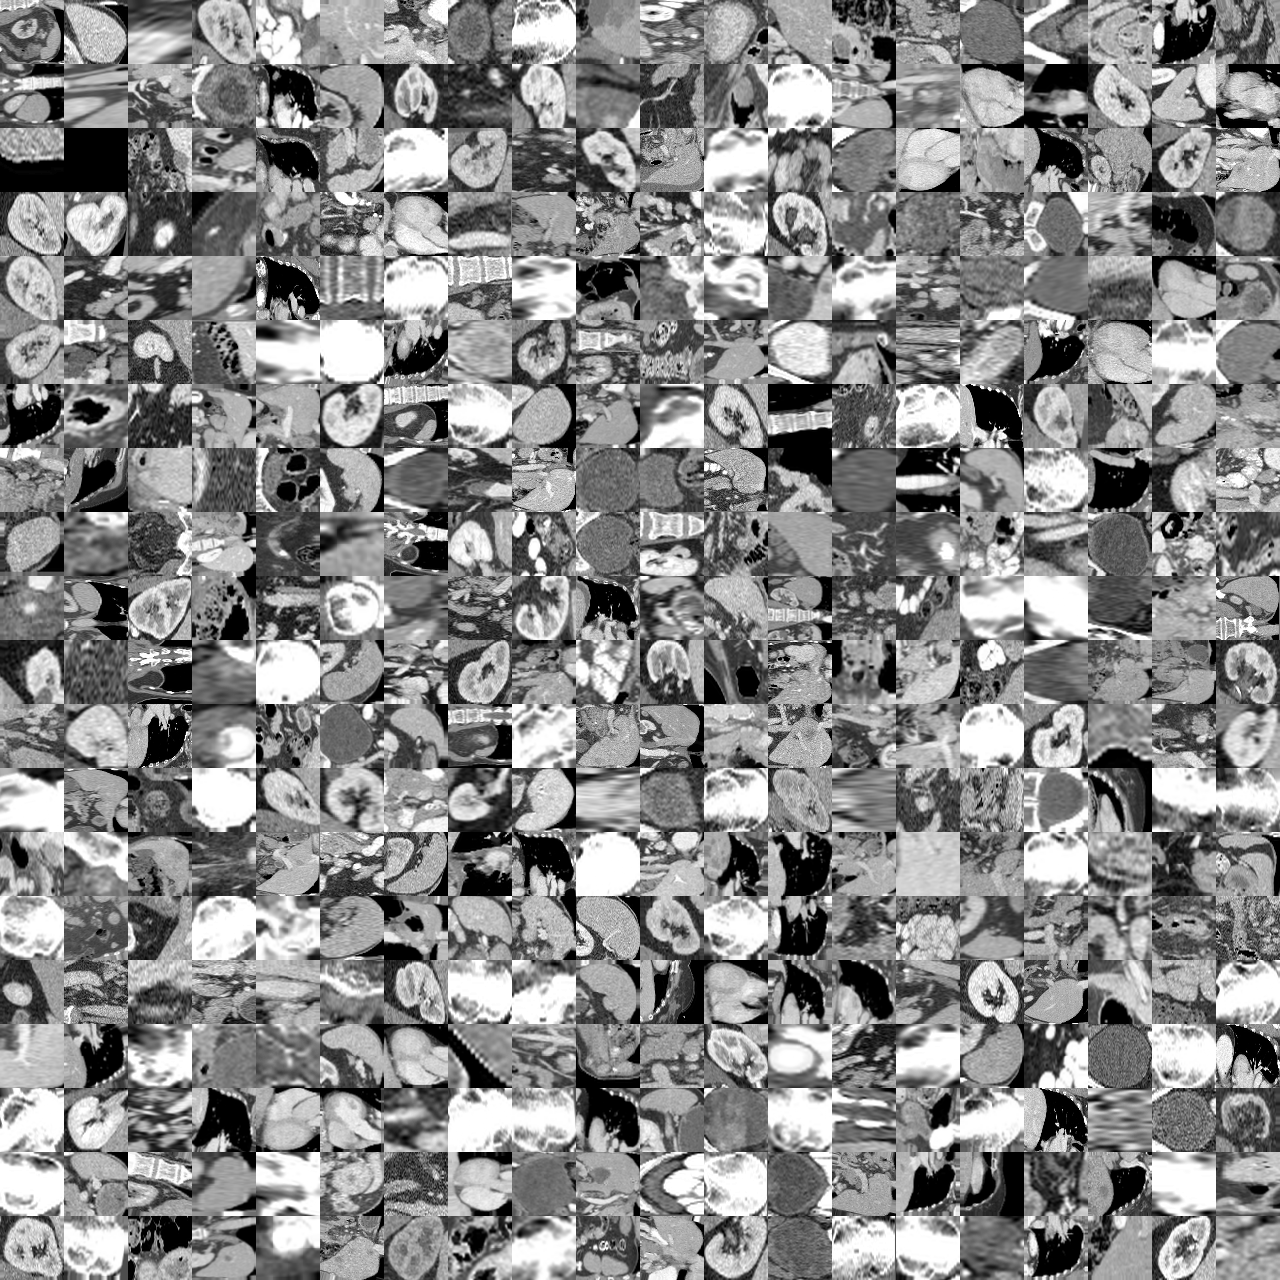

In [29]:
montage(train_dataset_, length=20, replace=False, flag = 'coronal')

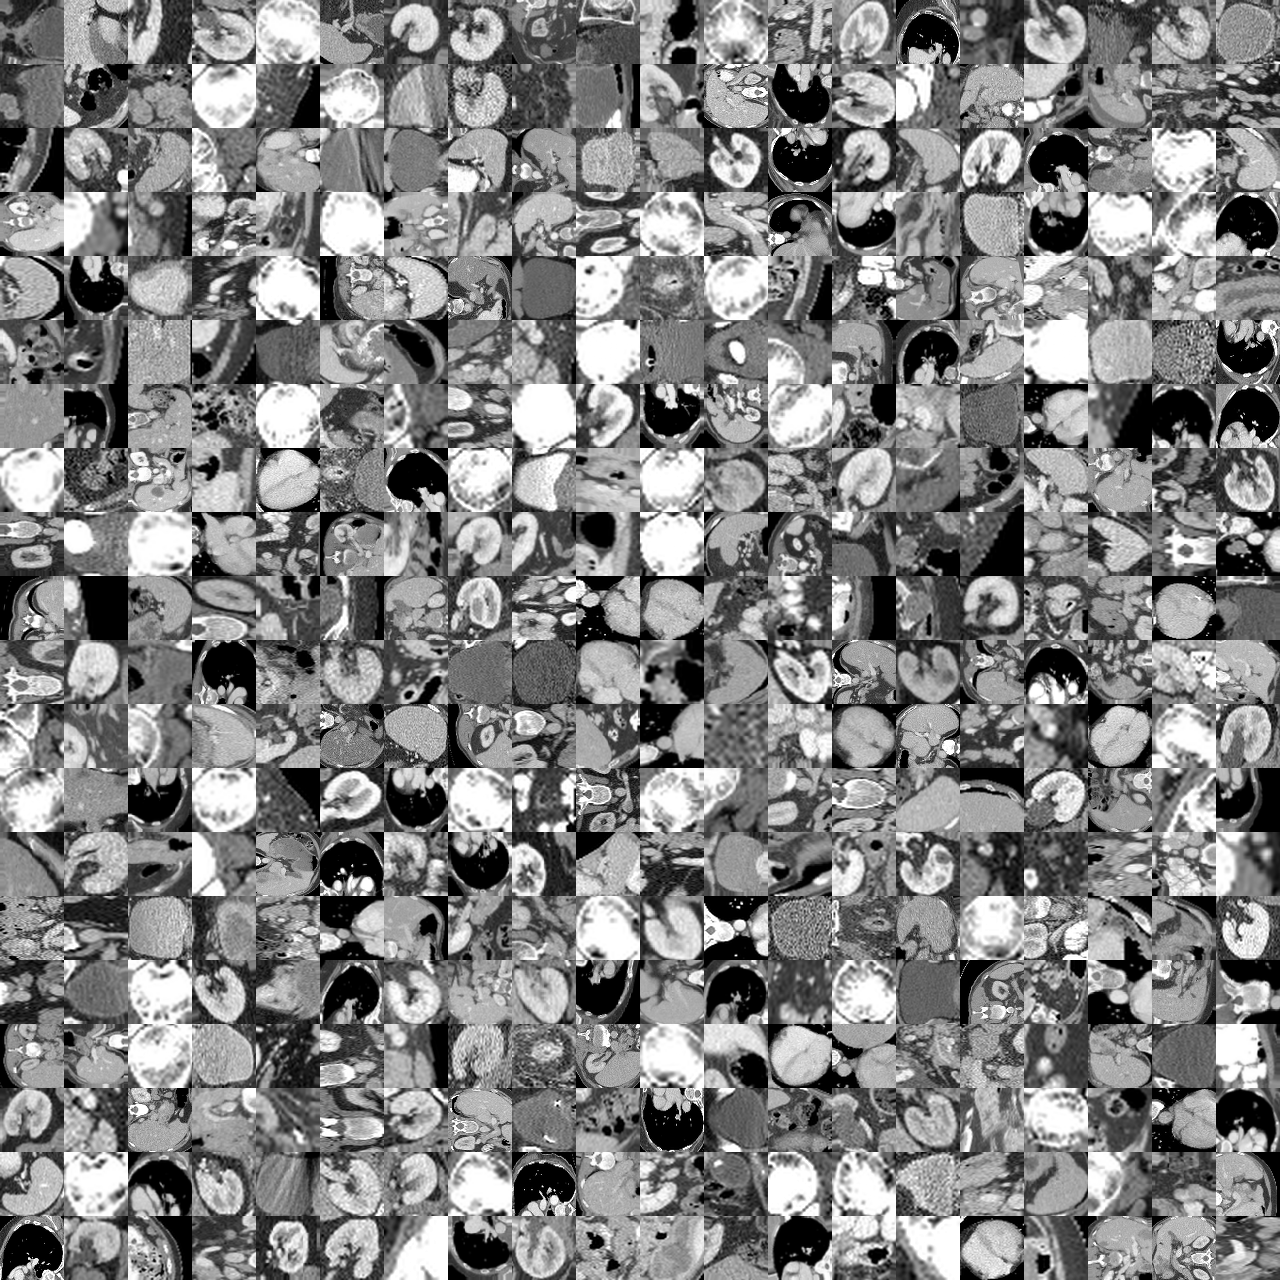

In [30]:
montage(train_dataset_, length=20, replace=False, flag = 'sagittal')

## Training cycle

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [19]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.6465
2/30, train_loss: 2.4812
3/30, train_loss: 2.4905
4/30, train_loss: 2.3298
5/30, train_loss: 2.2492
6/30, train_loss: 2.2115
7/30, train_loss: 2.4176
8/30, train_loss: 2.0426
9/30, train_loss: 2.2734
10/30, train_loss: 2.1707
11/30, train_loss: 1.7905
12/30, train_loss: 2.1423
13/30, train_loss: 1.9956
14/30, train_loss: 1.9282
15/30, train_loss: 2.2327
16/30, train_loss: 1.9796
17/30, train_loss: 1.9211
18/30, train_loss: 1.9746
19/30, train_loss: 2.1175
20/30, train_loss: 1.8969
21/30, train_loss: 2.2349
22/30, train_loss: 1.7682
23/30, train_loss: 1.6901
24/30, train_loss: 1.7640
25/30, train_loss: 2.0371
26/30, train_loss: 1.9357
27/30, train_loss: 1.9940
28/30, train_loss: 1.8503
29/30, train_loss: 1.7935
30/30, train_loss: 1.9011
31/30, train_loss: 1.4849
epoch 1 average loss: 2.0563
1
saved new best metric model
current epoch: 1 current AUC: 0.5450 current accuracy: 0.0932 best AUC: 0.5450 at epoch: 1
----------
epoch 2/100
1/30, t

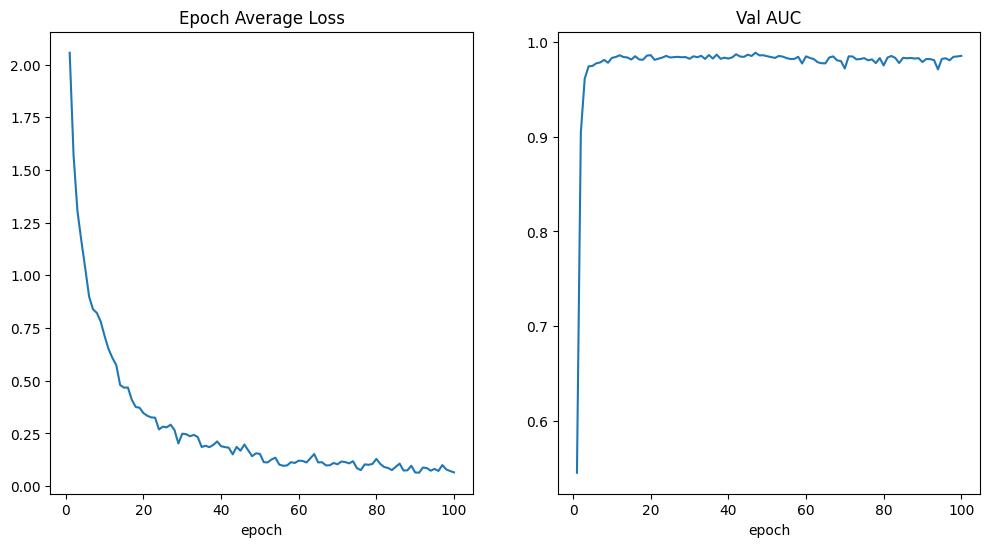

In [20]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [21]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [22]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9028    0.9420    0.9220        69
           1     0.4896    0.6912    0.5732        68
           2     0.5156    0.4783    0.4962        69
           3     0.5593    0.5077    0.5323        65
           4     0.5781    0.5692    0.5736        65
           5     0.8462    0.8333    0.8397        66
           6     0.8333    0.8929    0.8621        28
           7     0.9545    1.0000    0.9767        21
           8     1.0000    0.9524    0.9756        21
           9     0.6986    0.7391    0.7183        69
          10     0.7111    0.4638    0.5614        69

    accuracy                         0.6869       610
   macro avg     0.7354    0.7336    0.7301       610
weighted avg     0.6928    0.6869    0.6845       610



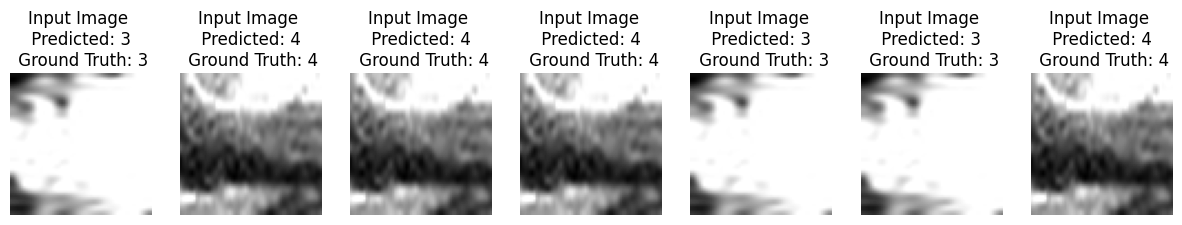

In [23]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, images.shape[0])
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(test_axial, pred, test_labels, n=7)

## Let's repeat the process for coronnal and sagittal parts of the dataset

### Training cycle for the coronal part

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [32]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.4258
2/30, train_loss: 2.4508
3/30, train_loss: 2.3511
4/30, train_loss: 2.2966
5/30, train_loss: 2.1840
6/30, train_loss: 2.2312
7/30, train_loss: 2.1827
8/30, train_loss: 2.1391
9/30, train_loss: 2.0483
10/30, train_loss: 2.0429
11/30, train_loss: 2.0062
12/30, train_loss: 2.0625
13/30, train_loss: 1.9827
14/30, train_loss: 1.9278
15/30, train_loss: 1.8384
16/30, train_loss: 1.9725
17/30, train_loss: 1.7507
18/30, train_loss: 1.8011
19/30, train_loss: 1.7065
20/30, train_loss: 1.6021
21/30, train_loss: 1.7475
22/30, train_loss: 1.7510
23/30, train_loss: 1.6903
24/30, train_loss: 1.9217
25/30, train_loss: 1.9119
26/30, train_loss: 1.6760
27/30, train_loss: 1.7992
28/30, train_loss: 1.8039
29/30, train_loss: 1.7497
30/30, train_loss: 1.5675
31/30, train_loss: 1.5958
epoch 1 average loss: 1.9425
1
saved new best metric model
current epoch: 1 current AUC: 0.5874 current accuracy: 0.0932 best AUC: 0.5874 at epoch: 1
----------
epoch 2/100
1/30, t

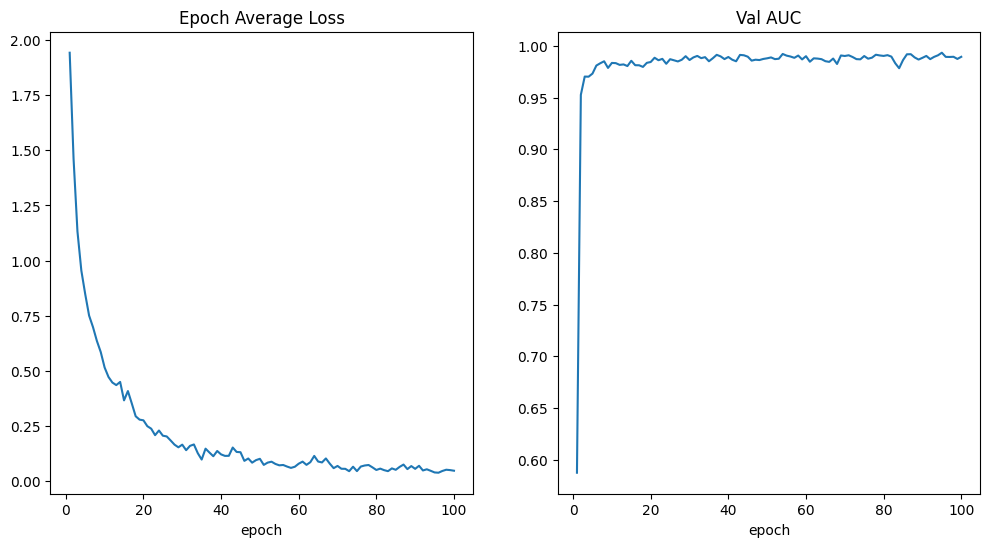

In [33]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [34]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [35]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8571    0.7826    0.8182        69
           1     0.4478    0.4412    0.4444        68
           2     0.4500    0.3913    0.4186        69
           3     0.4333    0.6000    0.5032        65
           4     0.4773    0.3231    0.3853        65
           5     0.6000    0.7273    0.6575        66
           6     0.5294    0.3214    0.4000        28
           7     0.8571    0.8571    0.8571        21
           8     0.9444    0.8095    0.8718        21
           9     0.6418    0.6232    0.6324        69
          10     0.4217    0.5072    0.4605        69

    accuracy                         0.5590       610
   macro avg     0.6055    0.5804    0.5863       610
weighted avg     0.5663    0.5590    0.5568       610



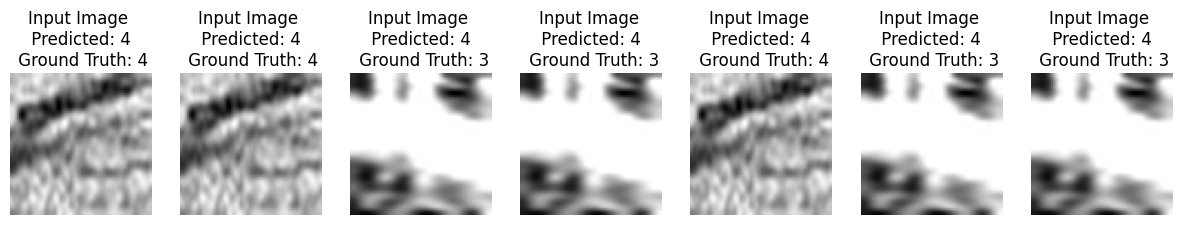

In [36]:
plot_examples(test_coronal, pred, test_labels, n=7)

### Training cycle for the sagittal part

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [38]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.3838
2/30, train_loss: 2.4351
3/30, train_loss: 2.2947
4/30, train_loss: 2.4585
5/30, train_loss: 2.2753
6/30, train_loss: 2.1187
7/30, train_loss: 2.1564
8/30, train_loss: 2.0053
9/30, train_loss: 2.0391
10/30, train_loss: 2.1208
11/30, train_loss: 2.0004
12/30, train_loss: 2.0461
13/30, train_loss: 1.9615
14/30, train_loss: 2.0477
15/30, train_loss: 1.9356
16/30, train_loss: 1.8576
17/30, train_loss: 1.7932
18/30, train_loss: 1.8888
19/30, train_loss: 1.8596
20/30, train_loss: 1.9352
21/30, train_loss: 1.9019
22/30, train_loss: 1.6433
23/30, train_loss: 1.8484
24/30, train_loss: 1.7451
25/30, train_loss: 1.9243
26/30, train_loss: 2.1010
27/30, train_loss: 1.8124
28/30, train_loss: 1.8698
29/30, train_loss: 1.8697
30/30, train_loss: 1.7731
31/30, train_loss: 1.8593
epoch 1 average loss: 1.9988
1
saved new best metric model
current epoch: 1 current AUC: 0.5257 current accuracy: 0.0932 best AUC: 0.5257 at epoch: 1
----------
epoch 2/100
1/30, t

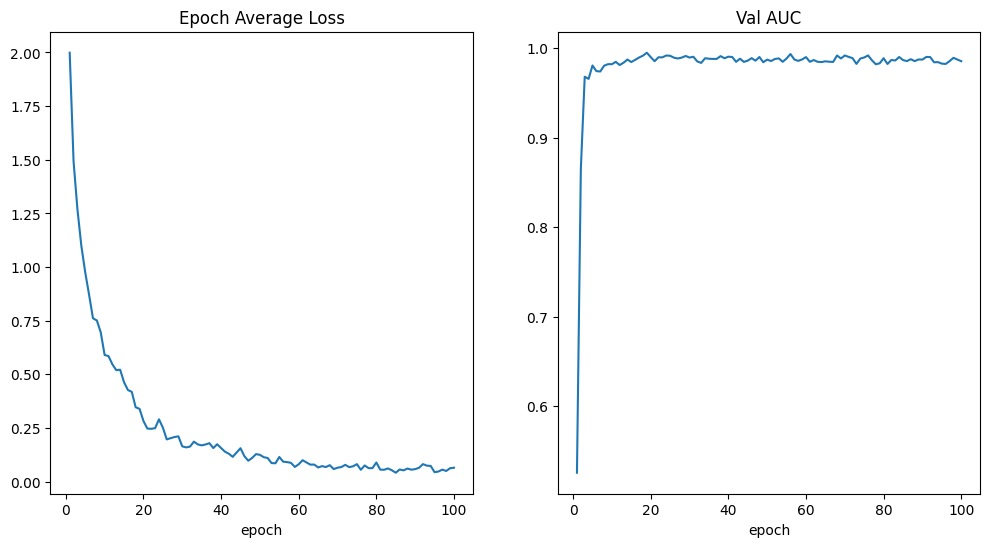

In [39]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [40]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [41]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.4054    0.6522    0.5000        69
           1     0.2222    0.1176    0.1538        68
           2     0.3061    0.2174    0.2542        69
           3     0.4909    0.4154    0.4500        65
           4     0.3833    0.3538    0.3680        65
           5     0.5952    0.3788    0.4630        66
           6     0.2105    0.1429    0.1702        28
           7     0.5143    0.8571    0.6429        21
           8     0.0000    0.0000    0.0000        21
           9     0.3385    0.3188    0.3284        69
          10     0.2500    0.4493    0.3212        69

    accuracy                         0.3574       610
   macro avg     0.3379    0.3548    0.3320       610
weighted avg     0.3567    0.3574    0.3431       610



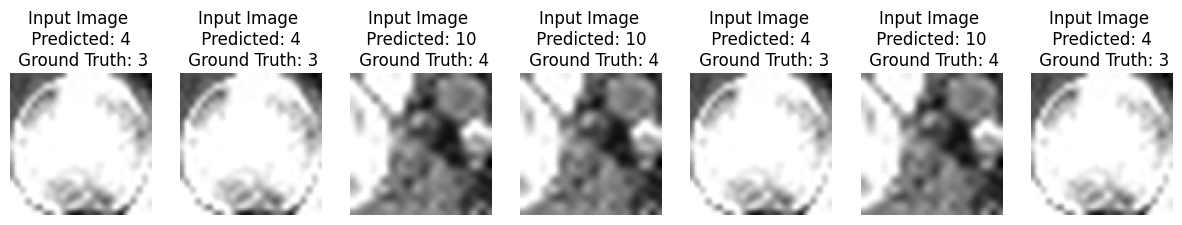

In [42]:
plot_examples(test_sagittal, pred, test_labels, n=7)

## Use 2d models as a backbone

In [107]:
# Load the pretrained models for each slice direction
model_axial = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [108]:
class CombinedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        # Assuming each model outputs a 512-dimension feature vector (from ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)

        # Get features from the respective models
        axial_features = self.model_axial(axial_slice).flatten(1)
        coronal_features = self.model_coronal(coronal_slice).flatten(1)
        sagittal_features = self.model_sagittal(sagittal_slice).flatten(1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

### Evaluate on a 3d dataset

In [109]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [110]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [111]:
for epoch in range(20):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.1414560810212167
Epoch 2, Loss: 1.3510318609976
Epoch 3, Loss: 0.8805350046004018
Epoch 4, Loss: 0.615842342376709
Epoch 5, Loss: 0.45969719079232985
Epoch 6, Loss: 0.37270518848972933
Epoch 7, Loss: 0.308184620834166
Epoch 8, Loss: 0.2611791712622489
Epoch 9, Loss: 0.23534079376728304
Epoch 10, Loss: 0.2056848435632644
Epoch 11, Loss: 0.19283328445688372
Epoch 12, Loss: 0.16856409825624957
Epoch 13, Loss: 0.1554870903491974
Epoch 14, Loss: 0.1578123055158123
Epoch 15, Loss: 0.13685475530162935
Epoch 16, Loss: 0.13189596057899536
Epoch 17, Loss: 0.11911413073539734
Epoch 18, Loss: 0.11121840738961773
Epoch 19, Loss: 0.11063086601995653
Epoch 20, Loss: 0.1031291781654281


In [112]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9942, Accuracy: 14.7329


In [113]:
combined_model.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = combined_model(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [114]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9571    0.9710    0.9640        69
           1     0.6515    0.6324    0.6418        68
           2     0.6269    0.6087    0.6176        69
           3     0.5625    0.6923    0.6207        65
           4     0.5714    0.4923    0.5289        65
           5     0.9831    0.8788    0.9280        66
           6     1.0000    0.8929    0.9434        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.7778    0.8116    0.7943        69
          10     0.9315    0.9855    0.9577        69

    accuracy                         0.7836       610
   macro avg     0.8238    0.8150    0.8179       610
weighted avg     0.7871    0.7836    0.7837       610



## Hyper network

In [80]:
class HyperNetwork(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=11):
        super(HyperNetwork, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])
        
        # Hypernetwork for weighting the features
        self.hyper_fc = nn.Sequential(
            nn.Linear(512 * 3, 256),  # Adjust based on feature size
            nn.ReLU(),
            nn.Linear(256, 512 * 3),
            nn.Sigmoid()
        )
        
        # Final classification layer
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)
        
        features_axial = self.model_axial(axial_slice).flatten(1)
        features_coronal = self.model_coronal(coronal_slice).flatten(1)
        features_sagittal = self.model_sagittal(sagittal_slice).flatten(1)
        
        combined_features = torch.cat([features_axial, features_coronal, features_sagittal], dim=1)
        
        # Apply hypernetwork to decide weights
        weights = self.hyper_fc(combined_features)
        combined_weighted_features = combined_features * weights
        
        # Final classification
        out = self.fc(combined_weighted_features)
        return out

In [81]:
# Load the pretrained models for each slice direction
model_axial = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [82]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [83]:
for epoch in range(30):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.212575997075727
Epoch 2, Loss: 1.740150317069023
Epoch 3, Loss: 1.386990197243229
Epoch 4, Loss: 1.1033228674242574
Epoch 5, Loss: 0.8904226614582923
Epoch 6, Loss: 0.747864180995572
Epoch 7, Loss: 0.6116616985490245
Epoch 8, Loss: 0.542490771701259
Epoch 9, Loss: 0.47221328750733405
Epoch 10, Loss: 0.4237742597056973
Epoch 11, Loss: 0.38820000521598325
Epoch 12, Loss: 0.33918760380437296
Epoch 13, Loss: 0.318626826328616
Epoch 14, Loss: 0.2869609704902095
Epoch 15, Loss: 0.2611622901693467
Epoch 16, Loss: 0.2620855627521392
Epoch 17, Loss: 0.22937679483044532
Epoch 18, Loss: 0.21345358990853833
Epoch 19, Loss: 0.20170645127373357
Epoch 20, Loss: 0.19171304087485036
Epoch 21, Loss: 0.18811221396730793
Epoch 22, Loss: 0.17830892267727083
Epoch 23, Loss: 0.16341049128001736
Epoch 24, Loss: 0.1607293414492761
Epoch 25, Loss: 0.15867438527845568
Epoch 26, Loss: 0.15399491979229835
Epoch 27, Loss: 0.1439514660066174
Epoch 28, Loss: 0.14061968581330392
Epoch 29, Loss: 0.1312

In [84]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9943, Accuracy: 14.7081


In [85]:
hypernetwork.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = hypernetwork(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [86]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9577    0.9855    0.9714        69
           1     0.6719    0.6324    0.6515        68
           2     0.6667    0.6087    0.6364        69
           3     0.5294    0.6923    0.6000        65
           4     0.5417    0.4000    0.4602        65
           5     0.9365    0.8939    0.9147        66
           6     1.0000    0.8929    0.9434        28
           7     1.0000    0.9524    0.9756        21
           8     0.9130    1.0000    0.9545        21
           9     0.7867    0.8551    0.8194        69
          10     0.9178    0.9710    0.9437        69

    accuracy                         0.7787       610
   macro avg     0.8110    0.8076    0.8064       610
weighted avg     0.7787    0.7787    0.7756       610

